# Manuscript Figures
Created by Ivan Lima on Wed Feb 22 2023 20:30:04 -0500

In [1]:
%matplotlib inline
import pandas as pd
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings, cmocean
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Thu Apr 20 11:38:33 2023


In [2]:
import sns_settings
# sns.set_context('paper')
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')
dpi = 600

## Temporal distribution of bottle and CTD data

In [3]:
# load bottle data
df_bottle_dic = pd.read_csv('data/bottle_data_DIC_prepared.csv', parse_dates=['Date'], index_col=0)
df_bottle_ta = pd.read_csv('data/bottle_data_TA_prepared.csv', parse_dates=['Date'], index_col=0)

# load CTD/WOD data
df_ctd = pd.read_hdf('data/CombinedCTD_satellite_bgc_2002-2018.h5', key='df_ctd')
# set seasons
df_ctd.loc[df_ctd.Date.dt.month.isin([1,2,12]),'Season'] = 'winter'
df_ctd.loc[df_ctd.Date.dt.month.isin([3,4,5]),'Season'] = 'spring'
df_ctd.loc[df_ctd.Date.dt.month.isin([6,7,8]),'Season'] = 'summer'
df_ctd.loc[df_ctd.Date.dt.month.isin([9,10,11]),'Season'] = 'fall'

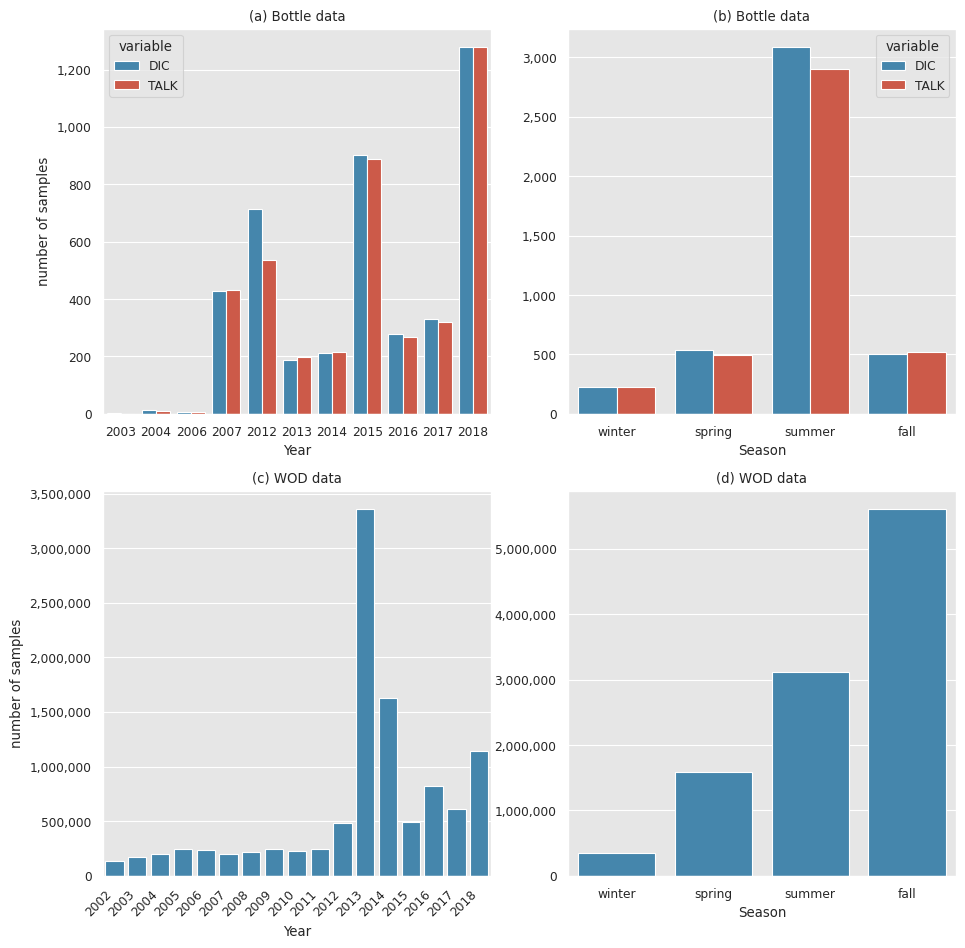

In [4]:
from matplotlib import ticker
fmt = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))

# prepare bottle data
df_dic1 = df_bottle_dic.groupby(df_bottle_dic.Date.dt.year)[['DIC']].count()
df_ta1 = df_bottle_ta.groupby(df_bottle_ta.Date.dt.year)[['TALK']].count()
df_year = (
    df_dic1.join(df_ta1)
    .fillna(0)
    .reset_index()
    .melt(value_vars=['DIC','TALK'], id_vars='Date')
    .rename(columns={'Date':'Year', 'value':'number of samples'})
)
df_dic2 = df_bottle_dic.groupby('Season')[['DIC']].count()
df_ta2 = df_bottle_ta.groupby('Season')[['TALK']].count()
df_season = (
    df_dic2.join(df_ta2)
    .fillna(0)
    .reset_index()
    .melt(value_vars=['DIC','TALK'], id_vars='Season')
    .rename(columns={'Date':'Year', 'value':'number of samples'})
)

# prepare CTD/WOD data
df_year_ctd = (
    df_ctd.groupby(df_ctd.Date.dt.year)[['Temperature']].count()
    .reset_index()
    .rename(columns={'Date':'Year',
                     'Temperature':'number of samples'})
)
df_season_ctd = (
    df_ctd.groupby('Season')[['Temperature']].count()
    .reset_index()
    .rename(columns={'Temperature':'number of samples'})
)

fig, axs = plt.subplots(2, 2, figsize=(11, 11))
_ = sns.barplot(x='Year', y='number of samples', data=df_year, hue='variable', ax=axs[0,0])
_ = sns.barplot(x='Season', y='number of samples', data=df_season, hue='variable', order=['winter','spring','summer','fall'], ax=axs[0,1])
_ = sns.barplot(x='Year', y='number of samples', data=df_year_ctd, color='C0', ax=axs[1,0])
_ = sns.barplot(x='Season', y='number of samples', data=df_season_ctd, color='C0', order=['winter','spring','summer','fall'], ax=axs[1,1])
_ = axs[0,0].set_title('(a) Bottle data')
_ = axs[0,1].set_title('(b) Bottle data')
_ = axs[1,0].set_title('(c) WOD data')
_ = axs[1,1].set_title('(d) WOD data')
_ = axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=45, ha='right')

for ax in axs[:,1]:
    _ = ax.set_ylabel('')

for ax in axs.ravel():
    _ = ax.yaxis.set_major_formatter(fmt)
    
fig.savefig('figures/data_distribution_time.png', dpi=dpi, bbox_inches='tight')
fig.savefig('figures/Figure_1.pdf', bbox_inches='tight')

## Model fit on test set 

In [5]:
# load DIC obs & predicted values
df_dic_all_vars = pd.read_csv('results/bottle_data_test_dic_all_vars.csv', index_col=0)
df_dic_all_noO2 = pd.read_csv('results/bottle_data_test_dic_noO2.csv', index_col=0)
df_dic_all_nosat = pd.read_csv('results/bottle_data_test_dic_nosat.csv', index_col=0)

# load TA obs & predicted values
df_ta_all_vars = pd.read_csv('results/bottle_data_test_ta_all_vars.csv', index_col=0)
df_ta_all_noO2 = pd.read_csv('results/bottle_data_test_ta_noO2.csv', index_col=0)
df_ta_all_nosat = pd.read_csv('results/bottle_data_test_ta_nosat.csv', index_col=0)

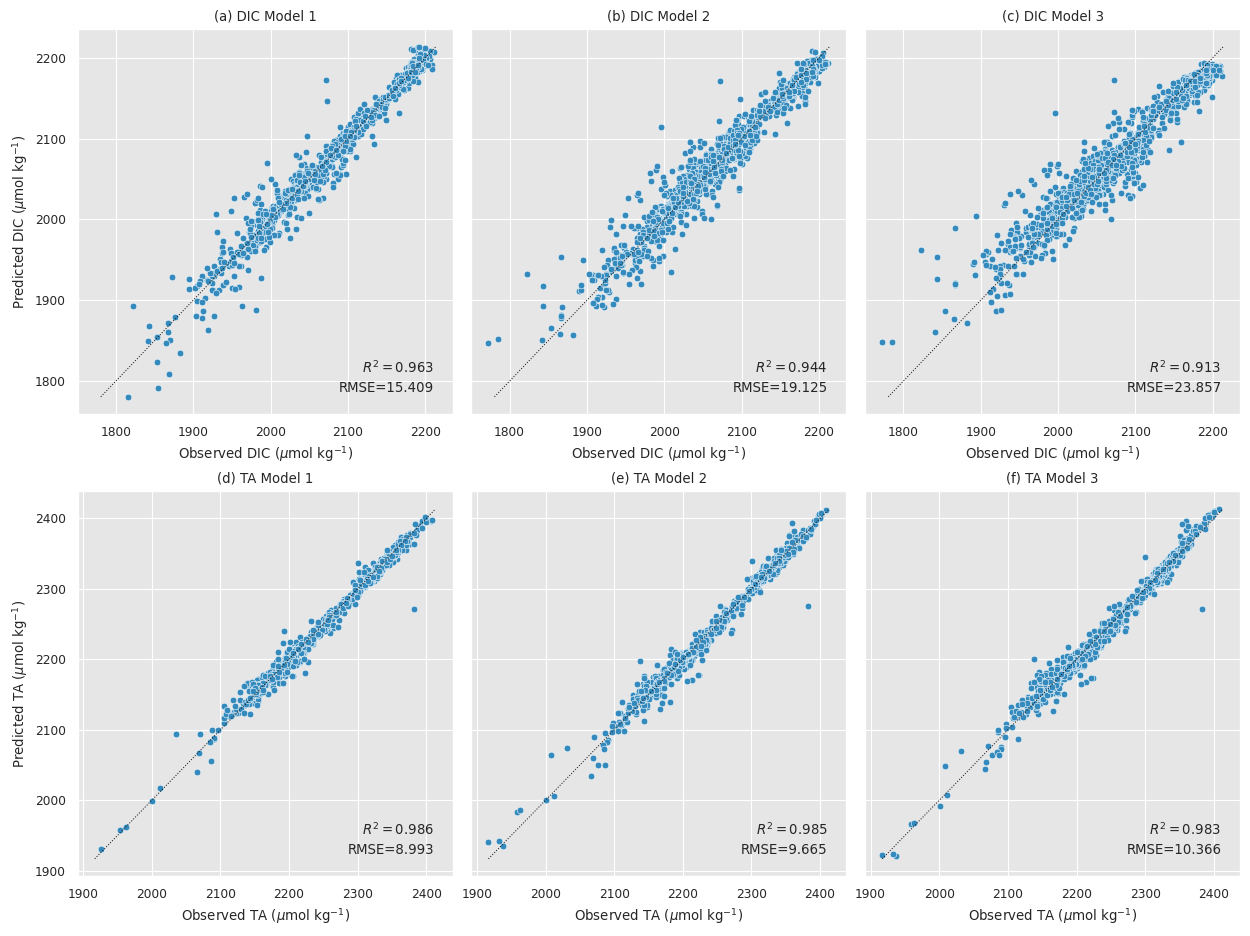

In [6]:
from sklearn.metrics import r2_score, mean_squared_error

fig, axs = plt.subplots(2, 3, sharex='row', sharey='row', figsize=(15, 11))
fig.subplots_adjust(wspace=0.05)
for ax, df in zip(axs[0,:], [df_dic_all_vars, df_dic_all_noO2, df_dic_all_nosat]):
    _ = sns.scatterplot(x='DIC observed', y='DIC predicted', data=df, ax=ax)
    r2 = r2_score(df['DIC observed'], df['DIC predicted'])
    rmse = mean_squared_error(df['DIC observed'], df['DIC predicted'], squared=False)
    _ = ax.text(0.95, 0.1, '$R^2={:.3f}$'.format(r2), transform=ax.transAxes, ha='right', va='bottom')
    _ = ax.text(0.95, 0.05, 'RMSE={:.3f}'.format(rmse), transform=ax.transAxes, ha='right', va='bottom')
    vminmax = [df_dic_all_vars['DIC predicted'].min(), df_dic_all_vars['DIC predicted'].max()]
    _ = ax.plot(vminmax, vminmax, ':', color='k', linewidth=0.75)

for ax, df in zip(axs[1,:], [df_ta_all_vars, df_ta_all_noO2, df_ta_all_nosat]):
    _ = sns.scatterplot(x='TA observed', y='TA predicted', data=df, ax=ax)
    r2 = r2_score(df['TA observed'], df['TA predicted'])
    rmse = mean_squared_error(df['TA observed'], df['TA predicted'], squared=False)
    _ = ax.text(0.95, 0.1, '$R^2={:.3f}$'.format(r2), transform=ax.transAxes, ha='right', va='bottom')
    _ = ax.text(0.95, 0.05, 'RMSE={:.3f}'.format(rmse), transform=ax.transAxes, ha='right', va='bottom')
    vminmax = [df_ta_all_nosat['TA observed'].min(), df_ta_all_nosat['TA predicted'].max()]
    _ = ax.plot(vminmax, vminmax, ':', color='k', linewidth=0.75)
    
for ax in axs[0,:]:
    ax.set(xlabel='Observed DIC ($\mu$mol kg$^{-1}$)', ylabel='Predicted DIC ($\mu$mol kg$^{-1}$)')
for ax in axs[1,:]:
    ax.set(xlabel='Observed TA ($\mu$mol kg$^{-1}$)', ylabel='Predicted TA ($\mu$mol kg$^{-1}$)')

labels = ['(a) DIC Model 1', '(b) DIC Model 2', '(c) DIC Model 3', '(d) TA Model 1', '(e) TA Model 2', '(f) TA Model 3']
for ax, label in zip(axs.ravel(), labels):
    # _ = ax.text(0.025, 0.97, '{}'.format(label), transform=ax.transAxes, ha='left', va='top')
    _ = ax.set_title(label)
    
fig.savefig('figures/model_fit_test_set.png', dpi=dpi, bbox_inches='tight')
fig.savefig('figures/Figure_5.pdf', bbox_inches='tight')

## Learning curves 

In [7]:
# load data for DIC models
df_history_dic_all_vars = pd.read_csv('results/nn_regression_history_dic_all_vars.csv', index_col=0)
df_history_dic_noO2 = pd.read_csv('results/nn_regression_history_dic_noO2.csv', index_col=0)
df_history_dic_nosat = pd.read_csv('results/nn_regression_history_dic_nosat.csv', index_col=0)

# load data for TA models
df_history_ta_all_vars = pd.read_csv('results/nn_regression_history_ta_all_vars.csv', index_col=0)
df_history_ta_noO2 = pd.read_csv('results/nn_regression_history_ta_noO2.csv', index_col=0)
df_history_ta_nosat = pd.read_csv('results/nn_regression_history_ta_nosat.csv', index_col=0)

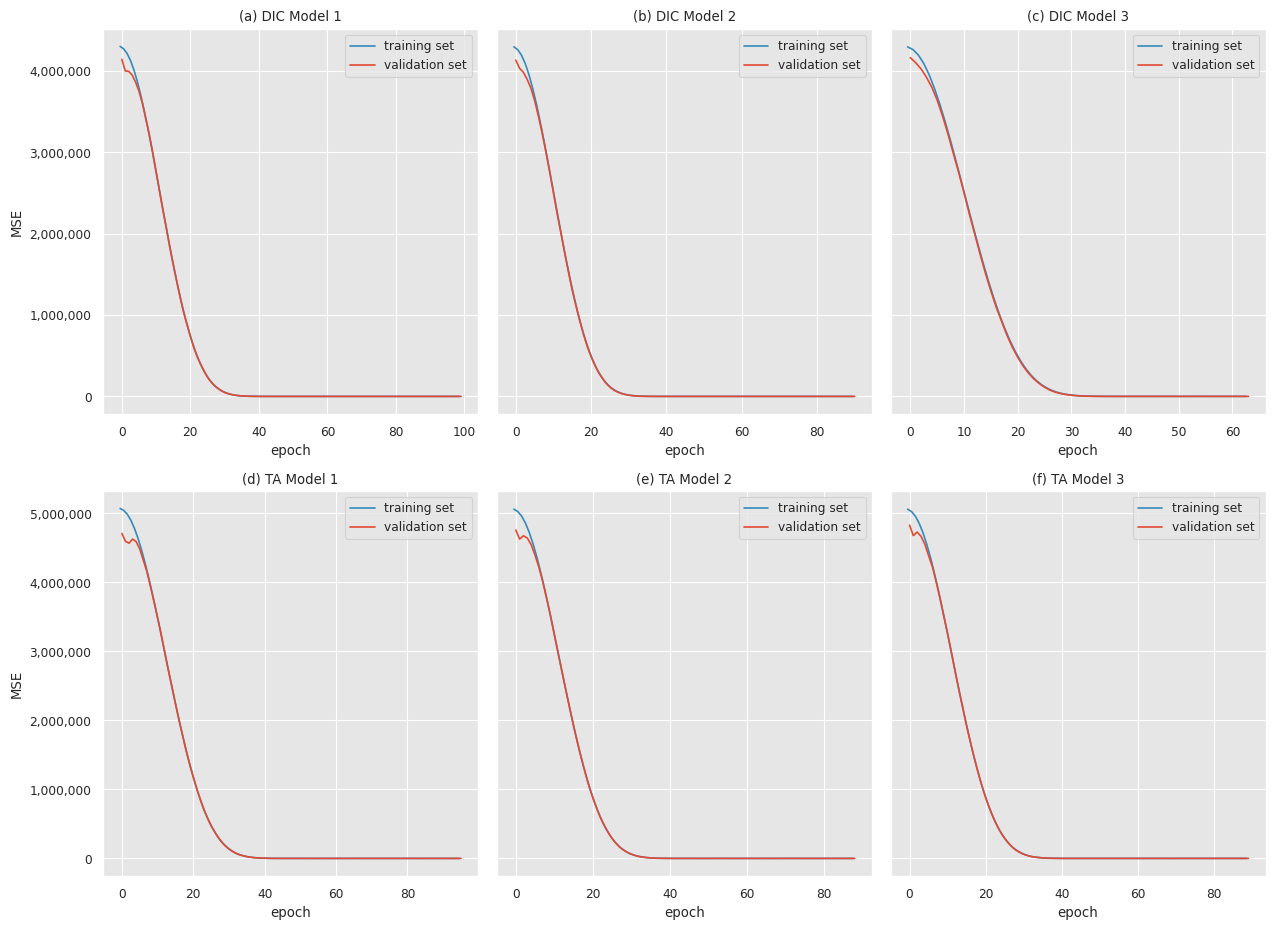

In [8]:
fig, axs = plt.subplots(2, 3, sharey='row', figsize=(15, 11))
fig.subplots_adjust(wspace=0.05)
for ax, df in zip(axs[0,:], [df_history_dic_all_vars, df_history_dic_noO2, df_history_dic_nosat]):
    _ = sns.lineplot(x=df.epoch-0.5, y='loss', data=df, ax=ax, label='training set')
    _ = sns.lineplot(x=df.epoch, y='val_loss', data=df, ax=ax, label='validation set')
    _ = ax.yaxis.set_major_formatter(fmt)
    _ = ax.set(ylabel = 'MSE')

for ax, df in zip(axs[1,:], [df_history_ta_all_vars, df_history_ta_noO2, df_history_ta_nosat]):
    _ = sns.lineplot(x=df.epoch-0.5, y='loss', data=df, ax=ax, label='training set')
    _ = sns.lineplot(x=df.epoch, y='val_loss', data=df, ax=ax, label='validation set')
    _ = ax.yaxis.set_major_formatter(fmt)
    _ = ax.set(ylabel = 'MSE')
    
labels = ['(a) DIC Model 1', '(b) DIC Model 2', '(c) DIC Model 3',
          '(d) TA Model 1', '(e) TA Model 2', '(f) TA Model 3']
for ax, label in zip(axs.ravel(), labels):
    _ = ax.set_title(label)

fig.savefig('figures/learning_curves.png', dpi=dpi, bbox_inches='tight')
fig.savefig('figures/Figure_3.pdf', bbox_inches='tight')

## Uncertainty

In [9]:
def compute_ensemble_stats(df, varname):
    df_out = df.drop(varname, axis=1).mean(axis=1).rename('ensemble_mean').to_frame()
    df_out['ensemble_std'] = df.drop(varname, axis=1).std(axis=1)
    df_out['ci95pct'] = df_out.ensemble_std * 1.96 # 95% confidence intervals
    df_out[varname] = df[varname]
    return df_out

# load ensemble prediction data
df_ens_dic_all_vars = pd.read_csv('results/ensemble_preds_dic_all_vars.csv', index_col=0)
df_ens_ta_all_vars = pd.read_csv('results/ensemble_preds_ta_all_vars.csv', index_col=0)
df_ens_dic_noO2 = pd.read_csv('results/ensemble_preds_dic_noO2.csv', index_col=0)
df_ens_ta_noO2 = pd.read_csv('results/ensemble_preds_ta_noO2.csv', index_col=0)
df_ens_dic_nosat = pd.read_csv('results/ensemble_preds_dic_nosat.csv', index_col=0)
df_ens_ta_nosat = pd.read_csv('results/ensemble_preds_ta_nosat.csv', index_col=0)

# compute stats for each point from ensemble
df_stats_dic_all_vars = compute_ensemble_stats(df_ens_dic_all_vars, 'DIC_observed')
df_stats_ta_all_vars = compute_ensemble_stats(df_ens_ta_all_vars, 'TA_observed')
df_stats_dic_noO2 = compute_ensemble_stats(df_ens_dic_noO2, 'DIC_observed')
df_stats_ta_noO2 = compute_ensemble_stats(df_ens_ta_noO2, 'TA_observed')
df_stats_dic_nosat = compute_ensemble_stats(df_ens_dic_nosat, 'DIC_observed')
df_stats_ta_nosat = compute_ensemble_stats(df_ens_ta_nosat, 'TA_observed')

df_std_all_vars = (
    df_stats_dic_all_vars[['ensemble_std']]
    .join(df_stats_ta_all_vars[['ensemble_std']], how='outer', lsuffix='DIC', rsuffix='TA')
    .rename(columns={'ensemble_stdDIC':'DIC', 'ensemble_stdTA':'TA'})
    .melt()
)
df_std_noO2 = (
    df_stats_dic_noO2[['ensemble_std']]
    .join(df_stats_ta_noO2[['ensemble_std']], how='outer', lsuffix='DIC', rsuffix='TA')
    .rename(columns={'ensemble_stdDIC':'DIC', 'ensemble_stdTA':'TA'})
    .melt()
)
df_std_nosat = (
    df_stats_dic_nosat[['ensemble_std']]
    .join(df_stats_ta_nosat[['ensemble_std']], how='outer', lsuffix='DIC', rsuffix='TA')
    .rename(columns={'ensemble_stdDIC':'DIC', 'ensemble_stdTA':'TA'})
    .melt()
)

# compute median std for DIC & TA
median_std_dic = np.array([df.ensemble_std.median() for df in [df_stats_dic_all_vars, df_stats_dic_noO2, df_stats_dic_nosat]])
median_std_ta = np.array([df.ensemble_std.median() for df in [df_stats_ta_all_vars, df_stats_ta_noO2, df_stats_ta_nosat]])

minvals = [df.ensemble_std.min() for df in [df_stats_dic_all_vars, df_stats_dic_noO2, df_stats_dic_nosat,
                                            df_stats_ta_all_vars, df_stats_ta_noO2, df_stats_ta_nosat]]
maxvals = [df.ensemble_std.max() for df in [df_stats_dic_all_vars, df_stats_dic_noO2, df_stats_dic_nosat,
                                            df_stats_ta_all_vars, df_stats_ta_noO2, df_stats_ta_nosat]]
std_min, std_max = min(minvals), max(maxvals)
bins = np.linspace(std_min, std_max, 50)

In [10]:
with np.printoptions(precision=3):
    print('DIC median std: {}'.format(median_std_dic))
    print('TA median std: {}'.format(median_std_ta))

DIC median std: [4.64  6.164 6.473]
TA median std: [2.957 3.112 2.853]


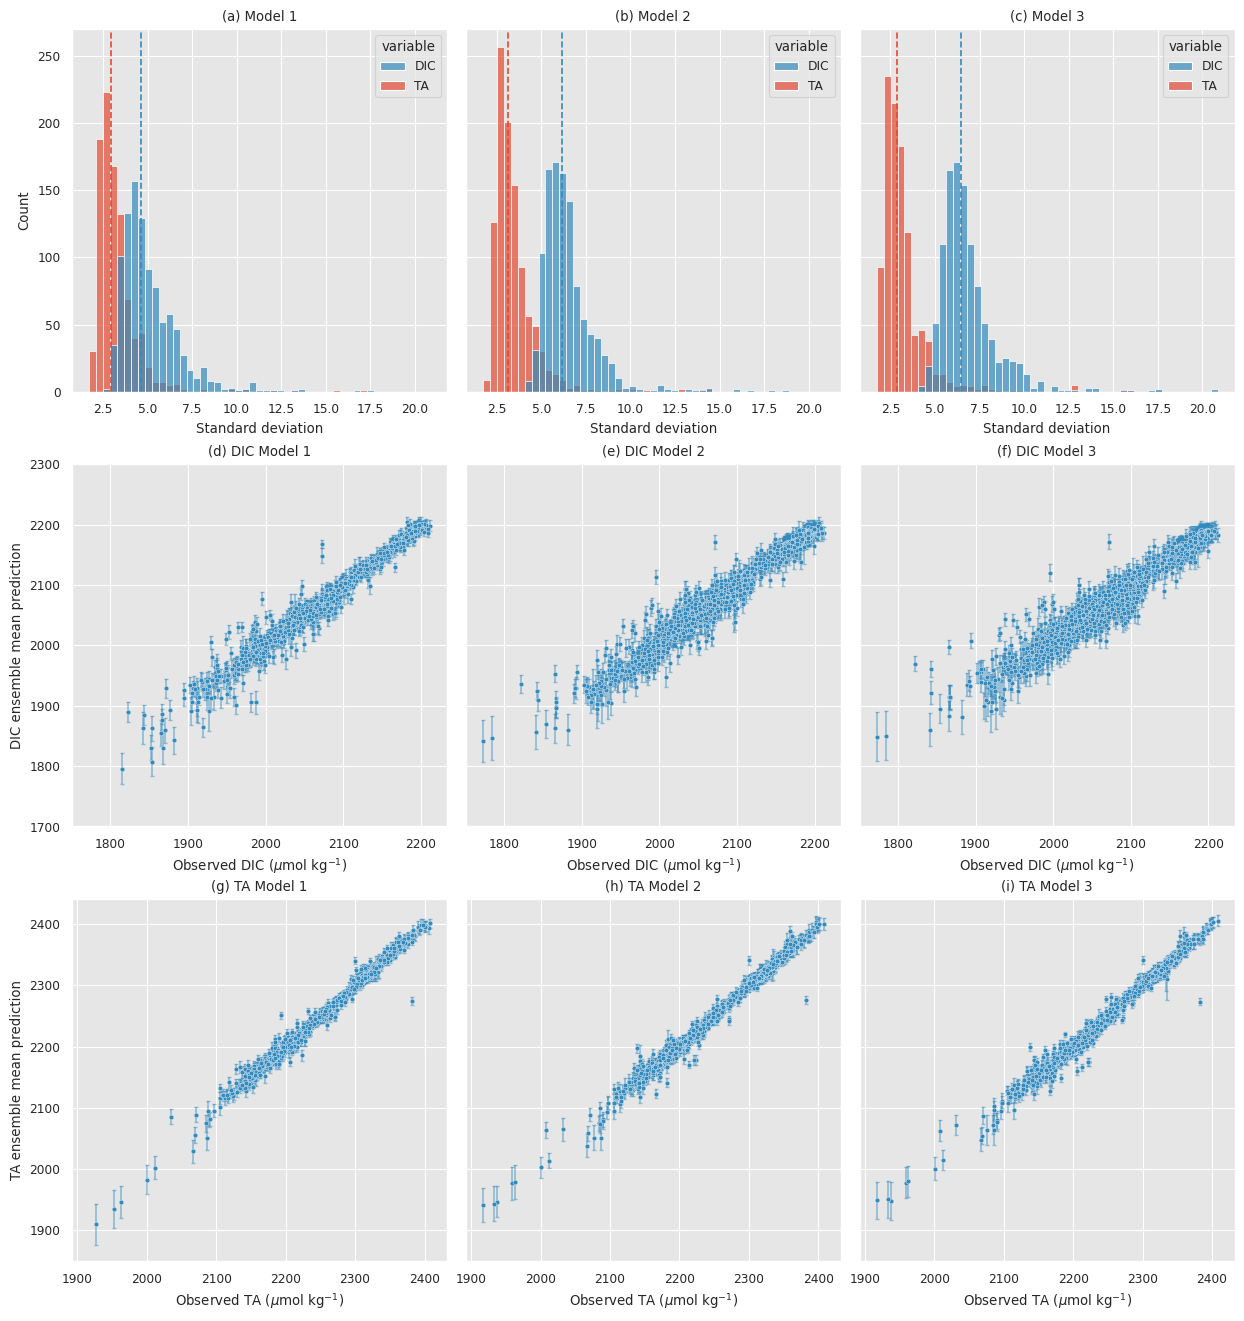

In [11]:
fig, axs = plt.subplots(3, 3, sharex='row', sharey='row', figsize=(15, 16))
fig.subplots_adjust(wspace=0.05)
for ax, df, mdic, mta in zip(axs[0,:], [df_std_all_vars, df_std_noO2, df_std_nosat], median_std_dic, median_std_ta):
    _ = sns.histplot(x='value', data=df, hue='variable', bins=bins, ax=ax, alpha=0.7)
    _ = ax.axvline(mdic, c='C0', ls='--')
    _ = ax.axvline(mta, c='C1', ls='--')
    _ = ax.set(xlabel='Standard deviation')
for ax, df in zip(axs[1,:], [df_stats_dic_all_vars, df_stats_dic_noO2, df_stats_dic_nosat]):
    _ = sns.scatterplot(x='DIC_observed', y='ensemble_mean', data=df, s=12, ax=ax, zorder=2)
    _ = ax.errorbar(df.DIC_observed, df.ensemble_mean, yerr=df.ci95pct, linestyle='', capsize=1.5, alpha=0.5, color='C0', zorder=1)
    _ = ax.set_yticks(ax.get_xticks())
    _ = ax.set(xlabel='Observed DIC ($\mu$mol kg$^{-1}$)')
for ax, df in zip(axs[2,:], [df_stats_ta_all_vars, df_stats_ta_noO2, df_stats_ta_nosat]):
    _ = sns.scatterplot(x='TA_observed', y='ensemble_mean', data=df, s=12, ax=ax, zorder=2)
    _ = ax.errorbar(df.TA_observed, df.ensemble_mean, yerr=df.ci95pct, linestyle='', capsize=1.5, alpha=0.5, color='C0', zorder=1)
    # _ = ax.set_yticks(ax.get_xticks())
    _ = ax.set(xlabel='Observed TA ($\mu$mol kg$^{-1}$)')
    
for ax, title in zip(axs[0,:], ['(a) Model 1', '(b) Model 2', '(c) Model 3']):
    ax.set_title(title)
    
for ax, title in zip(axs[1,:], ['(d) DIC Model 1', '(e) DIC Model 2', '(f) DIC Model 3']):
    ax.set_title(title)

for ax, title in zip(axs[2,:], ['(g) TA Model 1', '(h) TA Model 2', '(i) TA Model 3']):
    ax.set_title(title)
    
_ = axs[1,0].set_ylabel('DIC ensemble mean prediction')
_ = axs[2,0].set_ylabel('TA ensemble mean prediction')

# fig.savefig('figures/uncertainty.png', dpi=dpi, bbox_inches='tight')

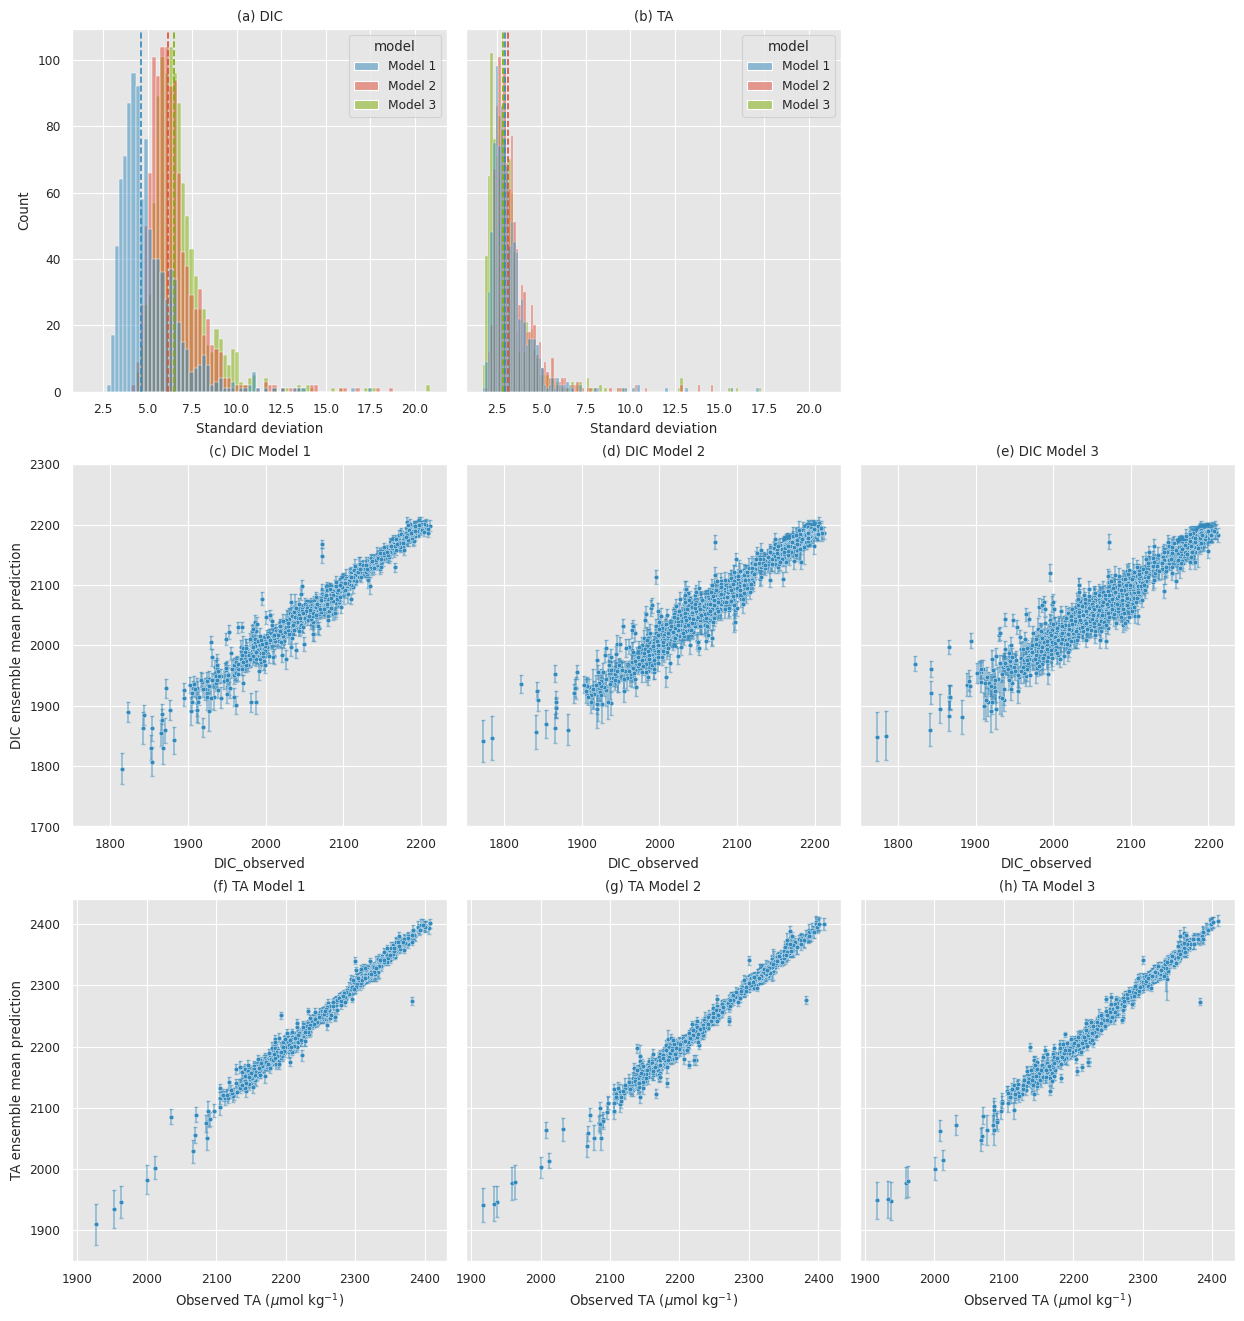

In [12]:
df_dic_std_all_vars = df_ens_dic_all_vars.drop('DIC_observed', axis=1).std(axis=1).rename('std').to_frame()
df_dic_std_noO2 = df_ens_dic_noO2.drop('DIC_observed', axis=1).std(axis=1).rename('std').to_frame()
df_dic_std_nosat = df_ens_dic_nosat.drop('DIC_observed', axis=1).std(axis=1).rename('std').to_frame()
df_dic_std_all_vars['model'] = 'Model 1'
df_dic_std_noO2['model'] = 'Model 2'
df_dic_std_nosat['model'] = 'Model 3'

df_ta_std_all_vars = df_ens_ta_all_vars.drop('TA_observed', axis=1).std(axis=1).rename('std').to_frame()
df_ta_std_noO2 = df_ens_ta_noO2.drop('TA_observed', axis=1).std(axis=1).rename('std').to_frame()
df_ta_std_nosat = df_ens_ta_nosat.drop('TA_observed', axis=1).std(axis=1).rename('std').to_frame()
df_ta_std_all_vars['model'] = 'Model 1'
df_ta_std_noO2['model'] = 'Model 2'
df_ta_std_nosat['model'] = 'Model 3'

df_dic_std = pd.concat([df_dic_std_all_vars, df_dic_std_noO2, df_dic_std_nosat], ignore_index=True)
df_ta_std = pd.concat([df_ta_std_all_vars, df_ta_std_noO2, df_ta_std_nosat], ignore_index=True)

fig, axs = plt.subplots(3, 3, sharex='row', sharey='row', figsize=(15, 16))
fig.subplots_adjust(wspace=0.05)
fig.delaxes(axs[0,2])

_ = sns.histplot(x='std', data=df_dic_std, hue='model', ax=axs[0,0])
for mdic, c in zip(median_std_dic, ['C0','C1','C2']):
    _ = axs[0,0].axvline(mdic, c=c, ls='--')
    _ = axs[0,0].set(xlabel='Standard deviation')
    
_ = sns.histplot(x='std', data=df_ta_std, hue='model', ax=axs[0,1])
for mta, c in zip(median_std_ta, ['C0','C1','C2']):
    _ = axs[0,1].axvline(mta, c=c, ls='--')
    _ = axs[0,1].set(xlabel='Standard deviation')

for ax, df in zip(axs[1,:], [df_stats_dic_all_vars, df_stats_dic_noO2, df_stats_dic_nosat]):
    _ = sns.scatterplot(x='DIC_observed', y='ensemble_mean', data=df, s=12, ax=ax, zorder=2)
    _ = ax.errorbar(df.DIC_observed, df.ensemble_mean, yerr=df.ci95pct, linestyle='', capsize=1.5, alpha=0.5, color='C0', zorder=1)
    _ = ax.set_yticks(ax.get_xticks())

for ax, df in zip(axs[2,:], [df_stats_ta_all_vars, df_stats_ta_noO2, df_stats_ta_nosat]):
    _ = sns.scatterplot(x='TA_observed', y='ensemble_mean', data=df, s=12, ax=ax, zorder=2)
    _ = ax.errorbar(df.TA_observed, df.ensemble_mean, yerr=df.ci95pct, linestyle='', capsize=1.5, alpha=0.5, color='C0', zorder=1)
    # _ = ax.set_yticks(ax.get_xticks())
    _ = ax.set(xlabel='Observed TA ($\mu$mol kg$^{-1}$)')

for ax, title in zip(axs[0,:], ['(a) DIC', '(b) TA']):
    ax.set_title(title)

for ax, title in zip(axs[1,:], ['(c) DIC Model 1', '(d) DIC Model 2', '(e) DIC Model 3']):
    ax.set_title(title)

for ax, title in zip(axs[2,:], ['(f) TA Model 1', '(g) TA Model 2', '(h) TA Model 3']):
    ax.set_title(title)
    
_ = axs[1,0].set_ylabel('DIC ensemble mean prediction')
_ = axs[2,0].set_ylabel('TA ensemble mean prediction')

# fig.savefig('figures/uncertainty.png', dpi=dpi, bbox_inches='tight')

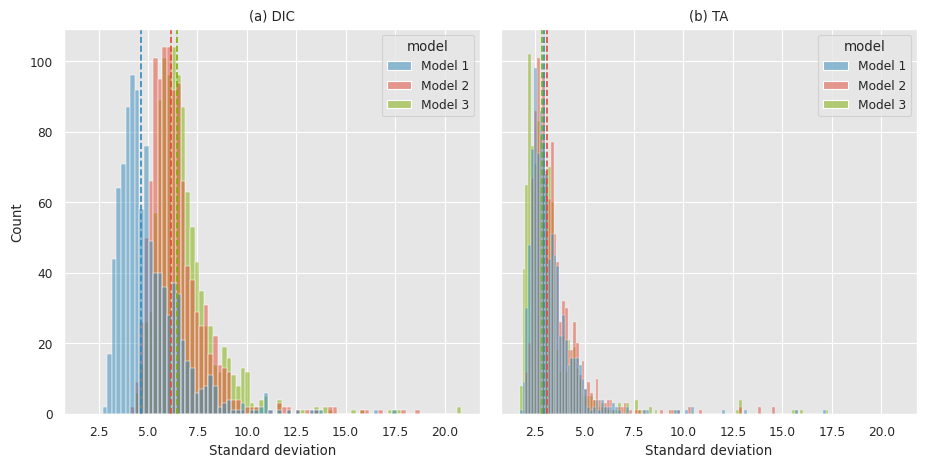

In [13]:
fig, axs = plt.subplots(1, 2, sharex='row', sharey='row', figsize=(11, 5))
fig.subplots_adjust(wspace=0.05)

_ = sns.histplot(x='std', data=df_dic_std, hue='model', ax=axs[0])
for mdic, c in zip(median_std_dic, ['C0','C1','C2']):
    _ = axs[0].axvline(mdic, c=c, ls='--')
    _ = axs[0].set(xlabel='Standard deviation')
    
_ = sns.histplot(x='std', data=df_ta_std, hue='model', ax=axs[1])
for mta, c in zip(median_std_ta, ['C0','C1','C2']):
    _ = axs[1].axvline(mta, c=c, ls='--')
    _ = axs[1].set(xlabel='Standard deviation')

for ax, title in zip(axs, ['(a) DIC', '(b) TA']):
    ax.set_title(title)

fig.savefig('figures/uncertainty.png', dpi=dpi, bbox_inches='tight')
fig.savefig('figures/Figure_6.pdf', bbox_inches='tight')

### DIC std

In [14]:
min_vals = [df['std'].min() for df in [df_dic_std_all_vars, df_dic_std_noO2, df_dic_std_nosat]]
max_vals = [df['std'].max() for df in [df_dic_std_all_vars, df_dic_std_noO2, df_dic_std_nosat]]
median_vals = [df['std'].median() for df in [df_dic_std_all_vars, df_dic_std_noO2, df_dic_std_nosat]]
pd.DataFrame({'min': min_vals, 'max': max_vals, 'median': median_vals}, index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,min,max,median
Model 1,2.703,17.416,4.640
Model 2,4.199,18.542,6.164
Model 3,4.342,20.846,6.473


### TA std

In [15]:
min_vals = [df['std'].min() for df in [df_ta_std_all_vars, df_ta_std_noO2, df_ta_std_nosat]]
max_vals = [df['std'].max() for df in [df_ta_std_all_vars, df_ta_std_noO2, df_ta_std_nosat]]
median_vals = [df['std'].median() for df in [df_ta_std_all_vars, df_ta_std_noO2, df_ta_std_nosat]]
pd.DataFrame({'min': min_vals, 'max': max_vals, 'median': median_vals}, index=['Model 1', 'Model 2', 'Model 3']).style.format('{:.3f}')

,min,max,median
Model 1,1.816,17.167,2.957
Model 2,1.989,14.577,3.112
Model 3,1.726,17.335,2.853


### Coefficient of Variation

#### DIC 

In [16]:
cv = (df_stats_dic_all_vars.ensemble_std / df_stats_dic_all_vars.ensemble_mean) * 100
print('{:.3f}% to {:.3f}%'.format(cv.min(), cv.max()))

0.130% to 0.914%


In [17]:
cv = (df_stats_dic_noO2.ensemble_std / df_stats_dic_noO2.ensemble_mean) * 100
print('{:.3f}% to {:.3f}%'.format(cv.min(), cv.max()))

0.208% to 1.004%


In [18]:
cv = (df_stats_dic_nosat.ensemble_std / df_stats_dic_nosat.ensemble_mean) * 100
print('{:.3f}% to {:.3f}%'.format(cv.min(), cv.max()))

0.211% to 1.127%


#### TA 

In [19]:
cv = (df_stats_ta_all_vars.ensemble_std / df_stats_ta_all_vars.ensemble_mean) * 100
print('{:.3f}% to {:.3f}%'.format(cv.min(), cv.max()))

0.078% to 0.899%


In [20]:
cv = (df_stats_ta_noO2.ensemble_std / df_stats_ta_noO2.ensemble_mean) * 100
print('{:.3f}% to {:.3f}%'.format(cv.min(), cv.max()))

0.085% to 0.750%


In [21]:
cv = (df_stats_ta_nosat.ensemble_std / df_stats_ta_nosat.ensemble_mean) * 100
print('{:.3f}% to {:.3f}%'.format(cv.min(), cv.max()))

0.075% to 0.818%


## Distribution of residuals by depth

In [22]:
df_dic_model1 = pd.read_csv('results/jennie_testset_dic_all_vars.csv', index_col=0)
df_dic_model2 = pd.read_csv('results/jennie_testset_dic_noO2.csv', index_col=0)
df_dic_model3 = pd.read_csv('results/jennie_testset_dic_nosat.csv', index_col=0)

df_ta_model1 = pd.read_csv('results/jennie_testset_ta_all_vars.csv', index_col=0)
df_ta_model2 = pd.read_csv('results/jennie_testset_ta_noO2.csv', index_col=0)
df_ta_model3 = pd.read_csv('results/jennie_testset_ta_nosat.csv', index_col=0)

In [23]:
def get_range(df):
    df.loc[df.Depth<15, 'Range'] = '< 15m'
    df.loc[df.Depth>=15, 'Range'] = '> 15m'
    return df

df_resid_dic_model1 = get_range(df_dic_model1)[['DIC residuals', 'Range']].rename(columns={'Range':'Depth'})
df_resid_dic_model2 = get_range(df_dic_model2)[['DIC residuals', 'Range']].rename(columns={'Range':'Depth'})
df_resid_dic_model3 = get_range(df_dic_model3)[['DIC residuals', 'Range']].rename(columns={'Range':'Depth'})

df_resid_ta_model1 = get_range(df_ta_model1)[['TA residuals', 'Range']].rename(columns={'Range':'Depth'})
df_resid_ta_model2 = get_range(df_ta_model2)[['TA residuals', 'Range']].rename(columns={'Range':'Depth'})
df_resid_ta_model3 = get_range(df_ta_model3)[['TA residuals', 'Range']].rename(columns={'Range':'Depth'})

median_dic_lt_15m =  [df.loc[df.Depth=='< 15m', 'DIC residuals'].median() for df in [df_resid_dic_model1, df_resid_dic_model2, df_resid_dic_model3]]
median_dic_gt_15m =  [df.loc[df.Depth=='> 15m', 'DIC residuals'].median() for df in [df_resid_dic_model1, df_resid_dic_model2, df_resid_dic_model3]]
median_ta_lt_15m =  [df.loc[df.Depth=='< 15m', 'TA residuals'].median() for df in [df_resid_ta_model1, df_resid_ta_model2, df_resid_ta_model3]]
median_ta_gt_15m =  [df.loc[df.Depth=='> 15m', 'TA residuals'].median() for df in [df_resid_ta_model1, df_resid_ta_model2, df_resid_ta_model3]]

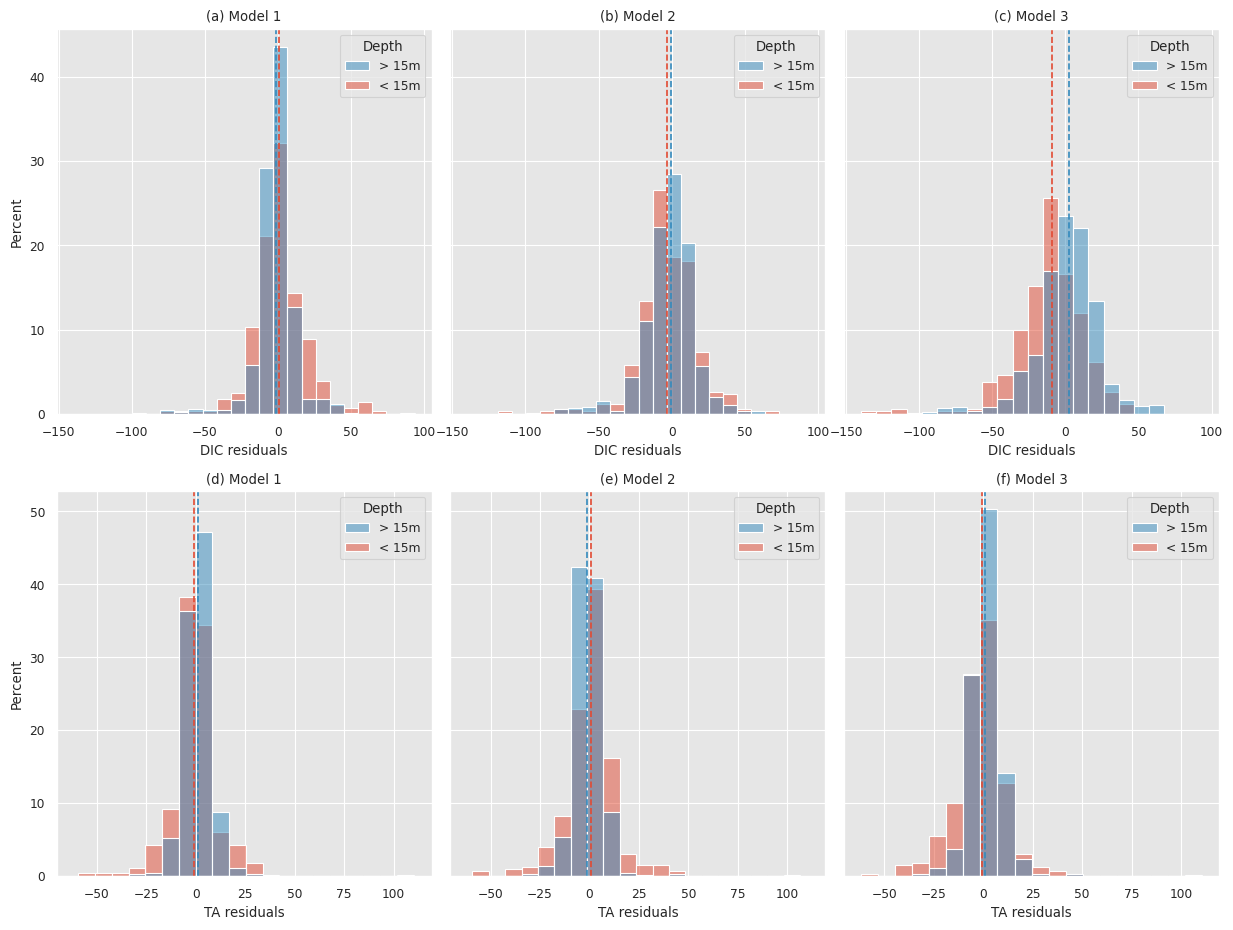

In [24]:
bins = 20
fig, axs = plt.subplots(2, 3, sharex='row', sharey='row', figsize=(15, 11))
fig.subplots_adjust(wspace=0.05)
for ax, df, mg, ml in zip(axs[0,:], [df_resid_dic_model1, df_resid_dic_model2, df_resid_dic_model3], median_dic_gt_15m, median_dic_lt_15m):
    _ = sns.histplot(x='DIC residuals', data=df, hue='Depth', hue_order=['> 15m', '< 15m'], bins=bins,
                     common_bins=True, stat='percent', common_norm=False, ax=ax)
    _ = ax.axvline(mg, c='C0', ls='--')
    _ = ax.axvline(ml, c='C1', ls='--')
for ax, df, mg, ml in zip(axs[1,:], [df_resid_ta_model1, df_resid_ta_model2, df_resid_ta_model3], median_ta_gt_15m, median_ta_lt_15m):
    _ = sns.histplot(x='TA residuals', data=df, hue='Depth', hue_order=['> 15m', '< 15m'], bins=bins,
                     common_bins=True, stat='percent', common_norm=False, ax=ax)
    _ = ax.axvline(mg, c='C0', ls='--')
    _ = ax.axvline(ml, c='C1', ls='--')
    
for ax, label in zip(axs.ravel(), ['(a) Model 1', '(b) Model 2' ,'(c) Model 3', '(d) Model 1', '(e) Model 2' ,'(f) Model 3']):
    _ = ax.set_title(label)

fig.savefig('figures/residuals.png', dpi=dpi, bbox_inches='tight')
fig.savefig('figures/Figure_9.pdf', bbox_inches='tight')